<a href="https://colab.research.google.com/github/victoriafabris/disciplina-dsp-audio-video/blob/main/atividade4/atividade_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [153]:
import numpy as np
from scipy import signal
import scipy.io.wavfile as wav
import math
import pandas as pd
from IPython import display

In [154]:
import matplotlib.pyplot as plt
from  matplotlib import patches, rcParams, figure

Audio original:

In [155]:
repository_raw_url = "https://github.com/victoriafabris/disciplina-dsp-audio-video/raw/main/atividade4"
filename = "fala-tom-alta-freq.wav"
display.Audio(f"{repository_raw_url}/{filename}")

### Análise no OceanAudio



Importando o áudio disponivel neste [link](https://github.com/victoriafabris/disciplina-dsp-audio-video/tree/main/atividade4) para o OceanAudio, fazemos sua análise. Na imagem abaixo observamos que o áudio possui aproximadamente a frequência de 8KHz.

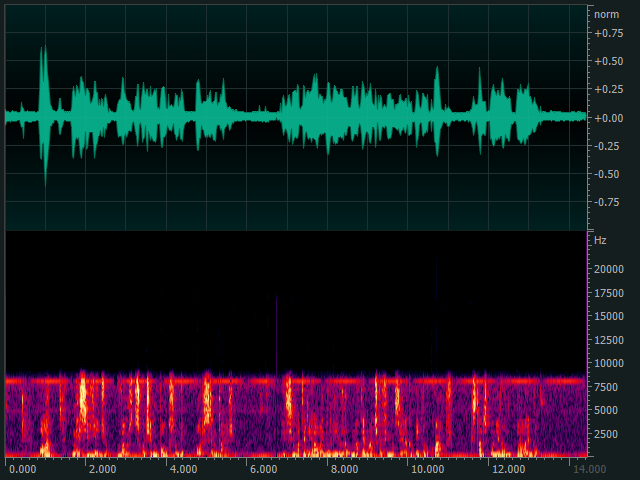

Agora aplicamos um filtro passa-baixas com os seguintes parâmetros:
- Banda passante: 1067Hz
- Decaimento: 20dB/década
- Atenuação da banda passante: 3dB

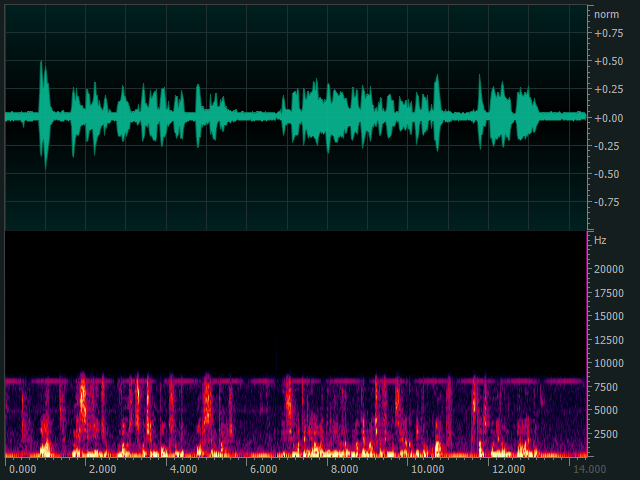

###Análise no Python

Agora, vamos visualizar via código python este sinal.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  """Entry point for launching an IPython kernel.


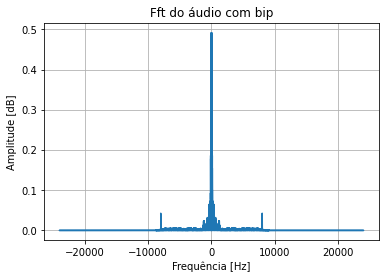

In [156]:
[fs,audio] = wav.read('/content/fala-tom-alta-freq.wav')
bip = audio/max(abs(audio))
fft = np.fft.fft(bip)
n = fft.size
freq = np.fft.fftfreq(n, 1/fs)

plt.plot(freq, abs(fft)*2/fs)
plt.grid()
plt.title("Fft do áudio com bip")
plt.xlabel("Frequência [Hz]")
plt.ylabel("Amplitude [dB]")
plt.show()

#### Definição das especificações

- Wp: frequência limite da banda de passagem (em rad/s);
- Ws: frequência limite da banda de rejeição (em rad/s);
- Wc: frequência de corte (em rad/s);
- Rp: máxima atenuação da banda de passagem (em dB, em Wp);
- Rs: mínima atenuação na banda de rejeição (em dB, em Ws)


In [157]:
#wc = (ws+wp)/2
fs=48000
wc=2*np.pi*6906/fs
ws = 2*np.pi*7500/fs
wp = 2*np.pi*6500/fs
tr_width = ws - wp
M = np.ceil(6.6*np.pi/tr_width) + 1 # cálculo da ordem M
n=np.arange(M)
Rp = 0.25
As = 50

##### Uso da função firwin()

Firwin function: This function computes the coefficients of a finite impulse response filter.

In [158]:
b = signal.firwin(numtaps = int(M), cutoff = wc/np.pi, window='hamming')

##### Função freqz modificada

Freqz function: Compute the frequency response of a digital filter.

In [159]:
def freqz_m(b,a):
    # Modified version of freqz subroutine
    # ------------------------------------
    # [db,mag,pha,grd,w] = freqz_m(b,a)
    #  db = Relative magnitude in dB computed over 0 to pi radians
    # mag = absolute magnitude computed over 0 to pi radians 
    # pha = Phase response in radians over 0 to pi radians
    # grd = Group delay over 0 to pi radians
    #   w = 501 frequency samples between 0 to pi radians
    #   b = numerator polynomial of H(z)   (for FIR: b=h)
    #   a = denominator polynomial of H(z) (for FIR: a=[1])
    #
    [w, H] = signal.freqz(b,a,worN=2048)
    db = 20*np.log10((np.abs(H))/np.max(np.abs(H)))
    w,grd = signal.group_delay((b,a),w)
    mag = np.abs(H)
    pha = np.angle(H)
    return db,mag,pha,grd,w

In [160]:
[db,mag,pha,grd,w] = freqz_m(b, a=1)

delta_w = np.pi/(len(w)-1)
Rp_calculado = -(np.min(db[0:int(wp/delta_w+1):]))       
As_calculado = -np.round(np.max(db[int(ws/delta_w):len(w)-1:]))

##### Função plot do plano z

In [161]:
def zplane(b,a,filename=None):
    ax = plt.subplot(111)

    uc = patches.Circle((0,0), radius=1, fill=False,
                        color='black', ls='dashed')
    ax.add_patch(uc)

    if np.max(b) > 1:
        kn = np.max(b)
        b = b/float(kn)
    else:
        kn = 1

    if np.max(a) > 1:
        kd = np.max(a)
        a = a/float(kd)
    else:
        kd = 1
        
    p = np.roots(a)
    z = np.roots(b)
    k = kn/float(kd)
    print(f"polos:{p}, zeros:{z}, k:{k}") 

    t1 = plt.plot(z.real, z.imag, 'go', ms=10)
    plt.setp( t1, markersize=10.0, markeredgewidth=1.0,
              markeredgecolor='k', markerfacecolor='g')

    t2 = plt.plot(p.real, p.imag, 'rx', ms=10)
    plt.setp( t2, markersize=12.0, markeredgewidth=3.0,
              markeredgecolor='r', markerfacecolor='r')

    ax.spines['left'].set_position('center')
    ax.spines['bottom'].set_position('center')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    r = 1.5; plt.axis('scaled'); plt.axis([-r, r, -r, r])
    ticks = [-1, -.5, .5, 1]; plt.xticks(ticks); plt.yticks(ticks)
    plt.xticks(ticks)
    plt.yticks(ticks)
    plt.show()

    return z, p, k

polos:[0.], zeros:[-1.31006288+0.j         -1.        +0.j         -0.99915265+0.04115804j
 -0.99915265-0.04115804j -0.99661914+0.08216016j -0.99661914-0.08216016j
 -0.99242228+0.12287397j -0.99242228-0.12287397j -0.98659286+0.16320089j
 -0.98659286-0.16320089j -0.97916378+0.20307214j -0.97916378-0.20307214j
 -0.97016683+0.2424383j  -0.97016683-0.2424383j  -0.95963175+0.28125951j
 -0.95963175-0.28125951j -0.94758661+0.31949902j -0.94758661-0.31949902j
 -0.93405859+0.35711981j -0.93405859-0.35711981j -0.91907476+0.39408323j
 -0.91907476-0.39408323j -0.90266271+0.43034873j -0.90266271-0.43034873j
 -0.88485102+0.46587409j -0.88485102-0.46587409j -0.86566956+0.50061584j
 -0.86566956-0.50061584j -0.84514967+0.53452974j -0.84514967-0.53452974j
 -0.82332433+0.56757118j -0.82332433-0.56757118j -0.80022822+0.59969559j
 -0.80022822-0.59969559j -0.77589773+0.63085872j -0.77589773-0.63085872j
 -0.75037097+0.66101695j -0.75037097-0.66101695j -0.7236878 +0.6901275j
 -0.7236878 -0.6901275j  -0.695889

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


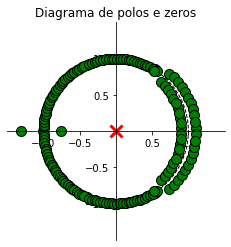

In [162]:
plt.figure()
plt.title("Diagrama de polos e zeros")
z,p,k = zplane(b, [1,0])
plt.show()

##### Visualizando respostas

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  after removing the cwd from sys.path.


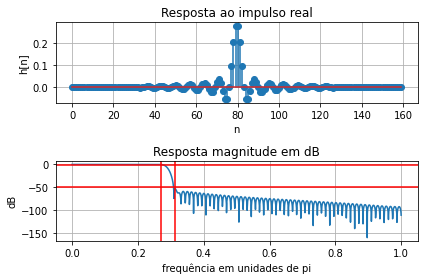

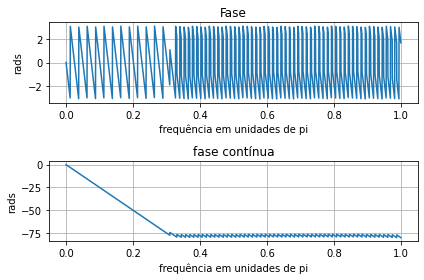

In [163]:
fig, axs = plt.subplots(nrows=2, ncols=1)

axs[0].set_title("Resposta ao impulso real")
axs[0].stem(n, b)
axs[0].grid()
axs[0].set_xlabel("n")
axs[0].set_ylabel("h[n]")

axs[1].set_title("Resposta magnitude em dB")
axs[1].plot(w/np.pi,db)
axs[1].grid()
axs[1].axhline(-Rp, color='r')
axs[1].axhline(-As, color='r')
axs[1].axvline(wp/np.pi, color='r')
axs[1].axvline(ws/np.pi, color='r')
axs[1].set_xlabel("frequência em unidades de pi")
axs[1].set_ylabel("dB")

fig.tight_layout()

fig, axs = plt.subplots(nrows=2, ncols=1)

axs[0].set_title("Fase")
axs[0].plot(w/np.pi,pha)
axs[0].grid()
axs[0].set_xlabel("frequência em unidades de pi")
axs[0].set_ylabel("rads")

axs[1].set_title("fase contínua")
axs[1].plot(w/np.pi,np.unwrap(pha))
axs[1].grid()
axs[1].set_xlabel("frequência em unidades de pi")
axs[1].set_ylabel("rads")

fig.tight_layout()


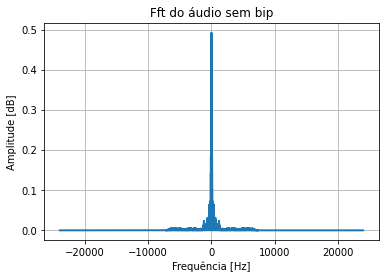

In [164]:
sem_bip = signal.lfilter(b, a =1, x = bip)
sem_bip = sem_bip/max(abs(sem_bip))

fft_sem_bip = np.fft.fft(sem_bip)
n = fft_sem_bip.size
freq = np.fft.fftfreq(n, 1/fs)

plt.plot(freq,abs(fft_sem_bip)*2/fs)
plt.grid()
plt.title("Fft do áudio sem bip")
plt.xlabel("Frequência [Hz]")
plt.ylabel("Amplitude [dB]")
plt.show()

utilizar sweep p ver as frequencias reais

1. definicao especificacoes
2. calculo do filtro(h[n]=bs)
3. aplicar o filtro python (lfilter(b, a, x)) 
3.1 x = varredura (sweep ou ruido branco-utilizar os dois p ver a diferença)
3.2 x = audio